In [1]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS, TFT, PatchTST, TCN, DLinear, RNN, LSTM, Autoformer, BiTCN
from neuralforecast.losses.pytorch import MQLoss, MAE
import torch
import logging

# Set logging and seed for reproducibility
logging.basicConfig(level=logging.INFO)
torch.set_float32_matmul_precision('high')  # Optimize matrix multiplication precision
np.random.seed(42)


In [2]:
# %%
# 📌 Load Data
df = pd.read_csv("Data/Top_12_German_Companies_Financial_Data.csv")

In [3]:
# Select company
company = 'Merck KGaA'
sap_df = df[df["Company"] == company].copy()

# Convert date column and sort for proper time-series analysis
sap_df["Period"] = pd.to_datetime(sap_df["Period"], format="%m/%d/%Y")
sap_df = sap_df.sort_values(by="Period")

# Convert revenue to numeric and rename for NeuralForecast
sap_df["Revenue"] = pd.to_numeric(sap_df["Revenue"], errors="coerce")
sap_df = sap_df.rename(columns={"Period": "ds", "Revenue": "y"})
sap_df["unique_id"] = "all"  # Required by NeuralForecast
sap_df = sap_df[["unique_id", "ds", "y"]]

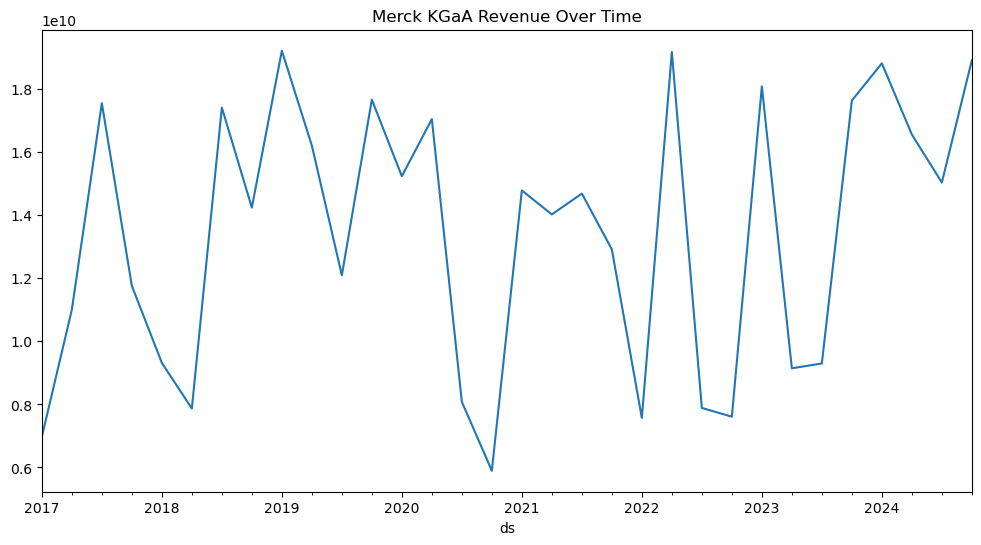

In [4]:
# Plot data
sap_df.plot(x="ds", y="y", figsize=(12, 6), title=f"{company} Revenue Over Time", legend=False)
plt.show()

In [5]:
# %%
# 📌 Train-Test Split
val_size = 4 # int(len(sap_df) * 0.2)
train, val = sap_df[:-val_size], sap_df[-val_size:]

In [6]:
# 📌 Custom SMAPE function
def smape_loss(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# 📌 Model Evaluation Function
def evaluate_model(y_true, y_pred, model_name, start_time):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    smape = smape_loss(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    runtime = time.time() - start_time

    return {
        "Model": model_name,
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "SMAPE": smape,
        "R² Score": r2,
        "Time (s)": runtime
    }


In [7]:
# 📌 Calculate Metrics for Each Model (Now Includes R² Score)
def calculate_metrics(y_true, y_pred):
    return {
        "MAE": np.mean(np.abs(y_true - y_pred)),
        "MSE": np.mean((y_true - y_pred) ** 2),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred) * 100,
        "SMAPE": smape_loss(y_true, y_pred),
        "R2 Score": r2_score(y_true, y_pred)  # ✅ Added R² Score
    }

In [8]:
# %%
# 📌 Define Models
def get_models(input_size=12):
    return [
        NBEATS(h=12, input_size=input_size, loss=MQLoss(), alias='NBEATS'),
        NHITS(h=12, input_size=input_size, loss=MQLoss(), alias='NHITS'),
        DLinear(h=12, input_size=input_size, loss=MQLoss(), alias='DLinear'),
        RNN(h=12, input_size=input_size, loss=MAE(), alias='RNN'),
        LSTM(h=12, input_size=input_size, loss=MAE(), alias='LSTM'),
        TCN(h=12, input_size=input_size, loss=MQLoss(), alias='TCN'),
        BiTCN(h=12, input_size=input_size, loss=MQLoss(), alias='BiTCN'),
        TFT(h=12, input_size=input_size, loss=MQLoss(), alias='TFT'),
        PatchTST(h=12, input_size=input_size, loss=MQLoss(), alias='PatchTST'),
        Autoformer(h=12, input_size=input_size, loss=MQLoss(), alias='Autoformer'),
    ]

In [9]:
def walk_forward_validation(models, df, initial_train_size=0.6, forecast_horizon=12):
    """
    Perform Walk-Forward Validation with Expanding Training Window and Moving Test Set.
    Ensures the model is retrained at each step.
    """
    initial_train_split = int(len(df) * initial_train_size)  # Define initial training size
    results = {}

    for model in models:
        print(f"\n🚀 Running Expanding Window Walk-Forward Validation for {model.alias}...")

        predictions, actuals = [], []

        # Start with the initial training data
        train_end = initial_train_split

        while train_end < len(df) - forecast_horizon:
            train_df = df.iloc[:train_end]  # ✅ Training set expands at each step
            test_df = df.iloc[train_end:train_end + forecast_horizon]  # ✅ Test set moves forward

            # Ensure test set is not empty
            if test_df.empty:
                print(f"⚠ No test data available at train_end={train_end}. Breaking loop.")
                break

            # ✅ Train the model at each step (ensuring multiple training events)
            nf = NeuralForecast(models=[model], freq="Q")
            nf.fit(train_df)  # ✅ Retraining happens at each step

            # Generate predictions
            forecast_df = nf.predict()
            if forecast_df.empty:
                raise ValueError(f"Model {model.alias} returned empty predictions at train_end={train_end}.")

            # Handle different model output formats
            if f"{model.alias}-median" in forecast_df.columns:
                pred_column = f"{model.alias}-median"
            elif model.alias in forecast_df.columns:
                pred_column = model.alias
            else:
                raise ValueError(f"Expected column {model.alias} or {model.alias}-median missing in forecast output: {forecast_df.columns}")

            # Extract predictions for the forecast horizon
            pred_values = forecast_df.iloc[:forecast_horizon][pred_column].values
            predictions.extend(pred_values)

            # Get actual values for comparison
            actual_values = test_df["y"].values
            actuals.extend(actual_values)

            print(f"Step {train_end}: Trained on {len(train_df)} samples, Tested on {len(test_df)} samples")

            # ✅ Expand training window for next step
            train_end += forecast_horizon  # Move training forward step by step

        # Compute RMSE & MAPE
        if len(predictions) == 0 or len(actuals) == 0:
            raise ValueError(f"🚨 Predictions or Actuals list is empty for model {model.alias}")

        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        mape = mean_absolute_percentage_error(actuals, predictions)

        results[model.alias] = calculate_metrics(np.array(actuals), np.array(predictions))

        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(df["ds"].values[len(df) - len(actuals):], actuals, label="Actual")
        plt.plot(df["ds"].values[len(df) - len(actuals):], predictions, label=f"{model.alias} Predictions", linestyle="dashed")
        plt.legend()
        plt.title(f"Expanding Window Walk-Forward Validation: {model.alias}")
        plt.savefig(f"Results/{model.alias}_walk_forward.png")
        plt.show()

    return results


Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
GPU available: True (cuda), used: True



🚀 Running Expanding Window Walk-Forward Validation for NBEATS...


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
605       Non-trainable params
2.5 M     Total params
9.993     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 19: Trained on 19 samples, Tested on 4 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
605       Non-trainable params
2.5 M     Total params
9.993     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 23: Trained on 23 samples, Tested on 4 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
605       Non-trainable params
2.5 M     Total params
9.993     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 27: Trained on 27 samples, Tested on 4 samples


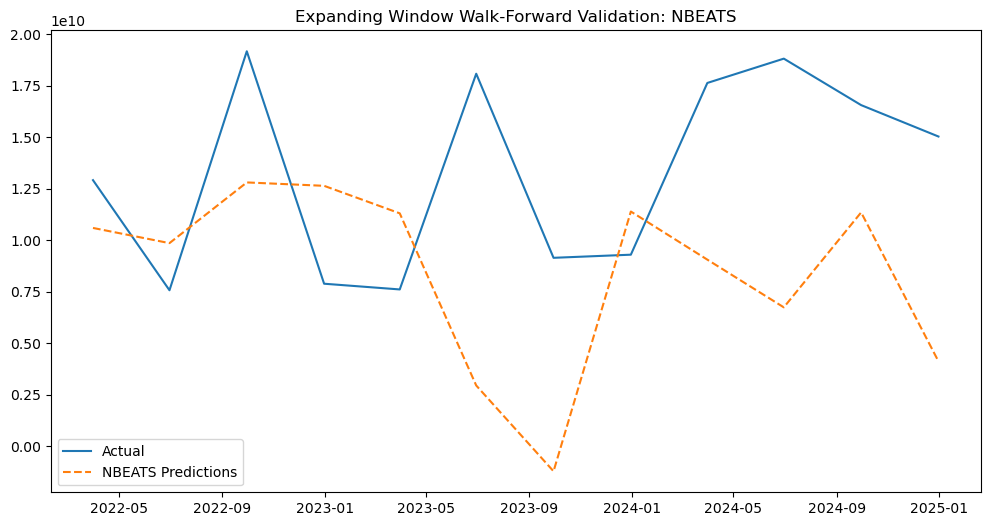

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



🚀 Running Expanding Window Walk-Forward Validation for NHITS...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
5         Non-trainable params
2.5 M     Total params
9.800     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 19: Trained on 19 samples, Tested on 4 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
5         Non-trainable params
2.5 M     Total params
9.800     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 23: Trained on 23 samples, Tested on 4 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
5         Non-trainable params
2.5 M     Total params
9.800     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 27: Trained on 27 samples, Tested on 4 samples


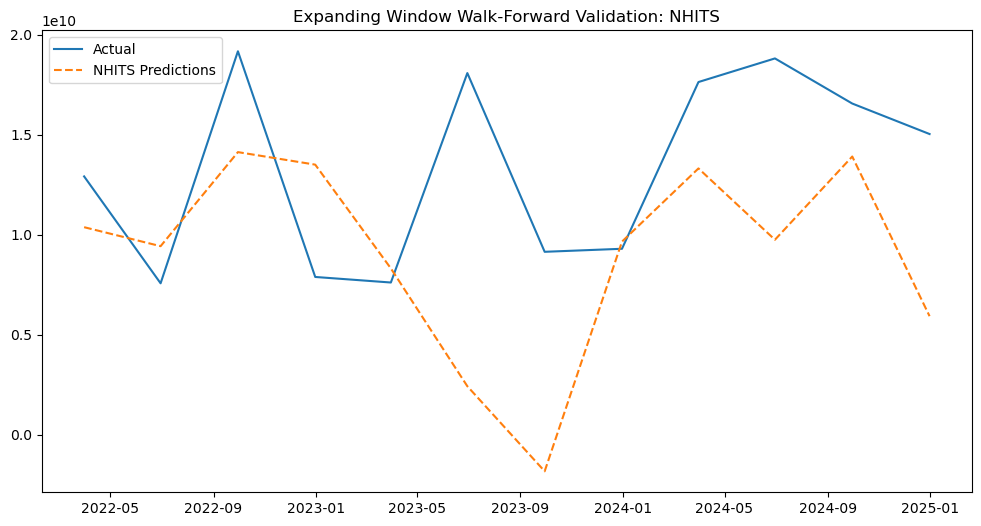

GPU available: True (cuda), used: True



🚀 Running Expanding Window Walk-Forward Validation for DLinear...


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MQLoss        | 5      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | linear_trend  | Linear        | 780    | train
5 | linear_season | Linear        | 780    | train
--------------------------------------------------------
1.6 K     Trainable params
5         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True


Step 19: Trained on 19 samples, Tested on 4 samples


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MQLoss        | 5      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | linear_trend  | Linear        | 780    | train
5 | linear_season | Linear        | 780    | train
--------------------------------------------------------
1.6 K     Trainable params
5         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Step 23: Trained on 23 samples, Tested on 4 samples


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MQLoss        | 5      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | linear_trend  | Linear        | 780    | train
5 | linear_season | Linear        | 780    | train
--------------------------------------------------------
1.6 K     Trainable params
5         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 27: Trained on 27 samples, Tested on 4 samples


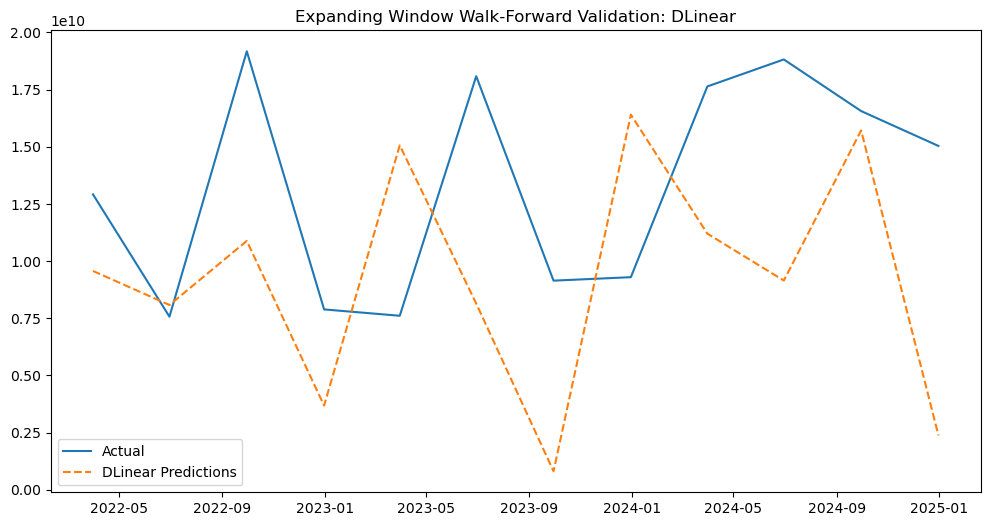

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



🚀 Running Expanding Window Walk-Forward Validation for RNN...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 24.1 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     Total params
0.590     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Step 19: Trained on 19 samples, Tested on 4 samples


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 24.1 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     Total params
0.590     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Step 23: Trained on 23 samples, Tested on 4 samples


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 24.1 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     Total params
0.590     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 27: Trained on 27 samples, Tested on 4 samples


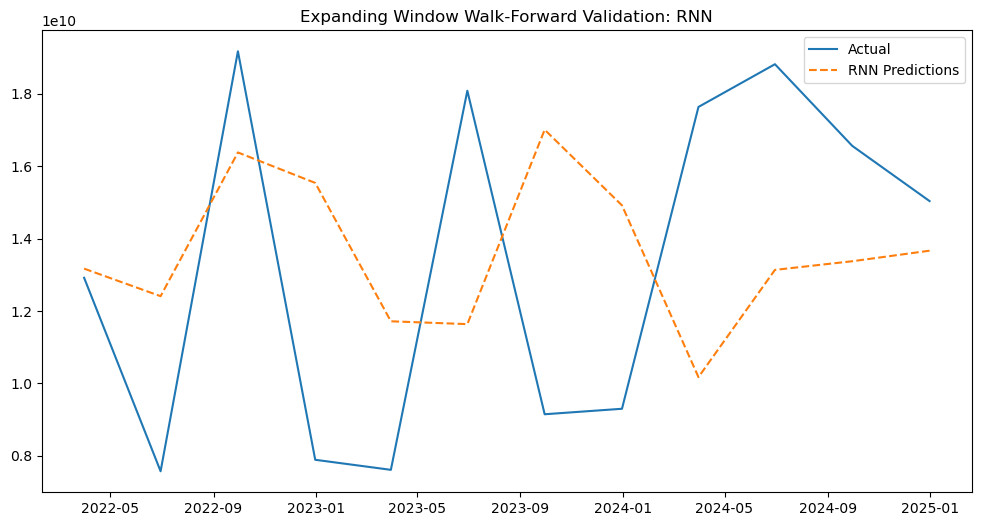


🚀 Running Expanding Window Walk-Forward Validation for LSTM...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 24.1 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
510 K     Trainable params
0         Non-trainable params
510 K     Total params
2.042     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Step 19: Trained on 19 samples, Tested on 4 samples


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 24.1 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
510 K     Trainable params
0         Non-trainable params
510 K     Total params
2.042     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Step 23: Trained on 23 samples, Tested on 4 samples


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 24.1 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
510 K     Trainable params
0         Non-trainable params
510 K     Total params
2.042     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 27: Trained on 27 samples, Tested on 4 samples


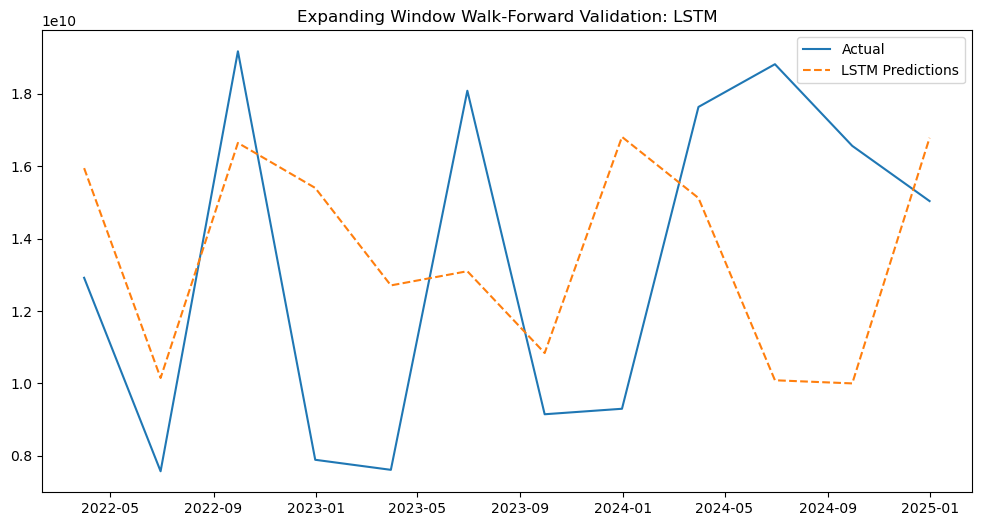

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



🚀 Running Expanding Window Walk-Forward Validation for TCN...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 24.1 K | train
5 | mlp_decoder     | MLP                        | 3.2 K  | train
-----------------------------------------------------------------------
348 K     Trainable params
5         Non-trainable params
348 K     Total params
1.395     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Step 19: Trained on 19 samples, Tested on 4 samples


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 24.1 K | train
5 | mlp_decoder     | MLP                        | 3.2 K  | train
-----------------------------------------------------------------------
348 K     Trainable params
5         Non-trainable params
348 K     Total params
1.395     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Step 23: Trained on 23 samples, Tested on 4 samples


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 24.1 K | train
5 | mlp_decoder     | MLP                        | 3.2 K  | train
-----------------------------------------------------------------------
348 K     Trainable params
5         Non-trainable params
348 K     Total params
1.395     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 27: Trained on 27 samples, Tested on 4 samples


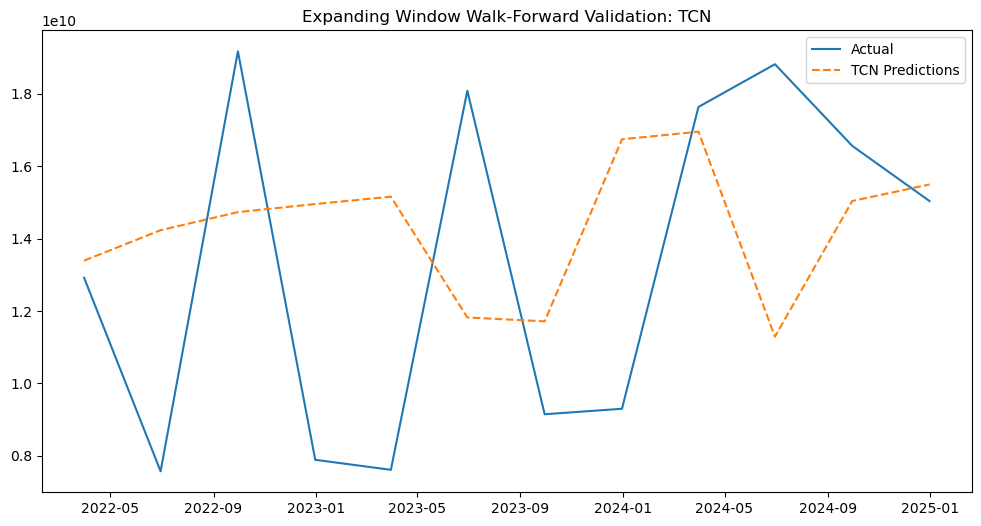

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



🚀 Running Expanding Window Walk-Forward Validation for BiTCN...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MQLoss        | 5      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | lin_hist      | Linear        | 32     | train
4 | drop_hist     | Dropout       | 0      | train
5 | net_bwd       | Sequential    | 4.3 K  | train
6 | drop_temporal | Dropout       | 0      | train
7 | temporal_lin1 | Linear        | 208    | train
8 | temporal_lin2 | Linear        | 204    | train
9 | output_lin    | Linear        | 85     | train
--------------------------------------------------------
4.8 K     Trainable params
5         Non-trainable params
4.8 K     Total params
0.019     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Step 19: Trained on 19 samples, Tested on 4 samples


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MQLoss        | 5      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | lin_hist      | Linear        | 32     | train
4 | drop_hist     | Dropout       | 0      | train
5 | net_bwd       | Sequential    | 4.3 K  | train
6 | drop_temporal | Dropout       | 0      | train
7 | temporal_lin1 | Linear        | 208    | train
8 | temporal_lin2 | Linear        | 204    | train
9 | output_lin    | Linear        | 85     | train
--------------------------------------------------------
4.8 K     Trainable params
5         Non-trainable params
4.8 K     Total params
0.019     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True


Step 23: Trained on 23 samples, Tested on 4 samples


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MQLoss        | 5      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | lin_hist      | Linear        | 32     | train
4 | drop_hist     | Dropout       | 0      | train
5 | net_bwd       | Sequential    | 4.3 K  | train
6 | drop_temporal | Dropout       | 0      | train
7 | temporal_lin1 | Linear        | 208    | train
8 | temporal_lin2 | Linear        | 204    | train
9 | output_lin    | Linear        | 85     | train
--------------------------------------------------------
4.8 K     Trainable params
5         Non-trainable params
4.8 K     Total params
0.019     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 27: Trained on 27 samples, Tested on 4 samples


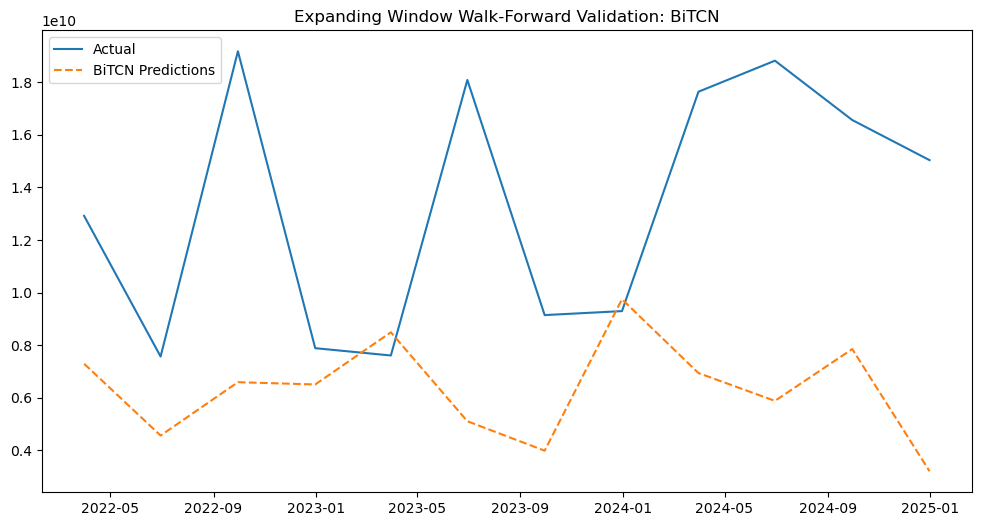

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



🚀 Running Expanding Window Walk-Forward Validation for TFT...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MQLoss                   | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 645    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.483     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Step 19: Trained on 19 samples, Tested on 4 samples


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MQLoss                   | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 645    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.483     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Step 23: Trained on 23 samples, Tested on 4 samples



  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MQLoss                   | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 645    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.483     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 27: Trained on 27 samples, Tested on 4 samples


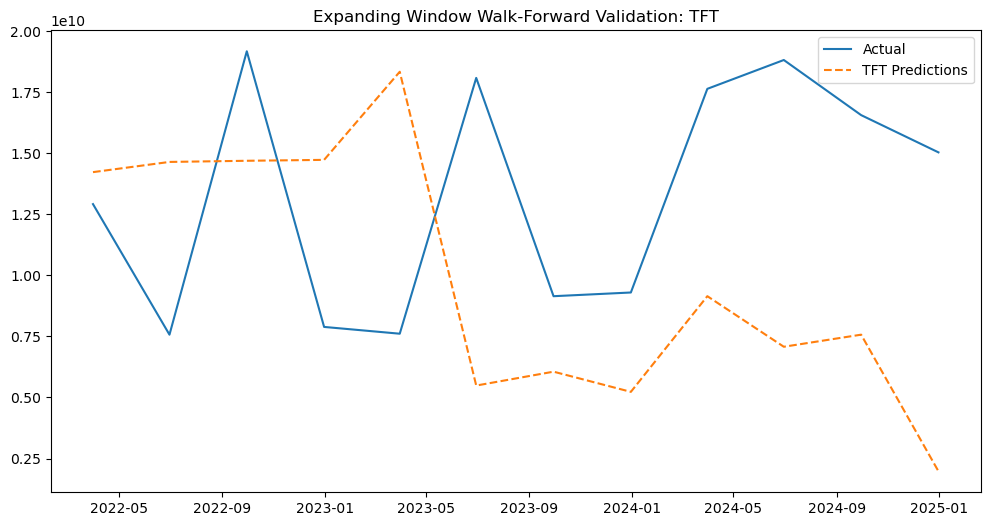

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



🚀 Running Expanding Window Walk-Forward Validation for PatchTST...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MQLoss            | 5      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 407 K  | train
-----------------------------------------------------------
407 K     Trainable params
8         Non-trainable params
407 K     Total params
1.630     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Step 19: Trained on 19 samples, Tested on 4 samples



  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MQLoss            | 5      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 407 K  | train
-----------------------------------------------------------
407 K     Trainable params
8         Non-trainable params
407 K     Total params
1.630     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Step 23: Trained on 23 samples, Tested on 4 samples



  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MQLoss            | 5      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 407 K  | train
-----------------------------------------------------------
407 K     Trainable params
8         Non-trainable params
407 K     Total params
1.630     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 27: Trained on 27 samples, Tested on 4 samples


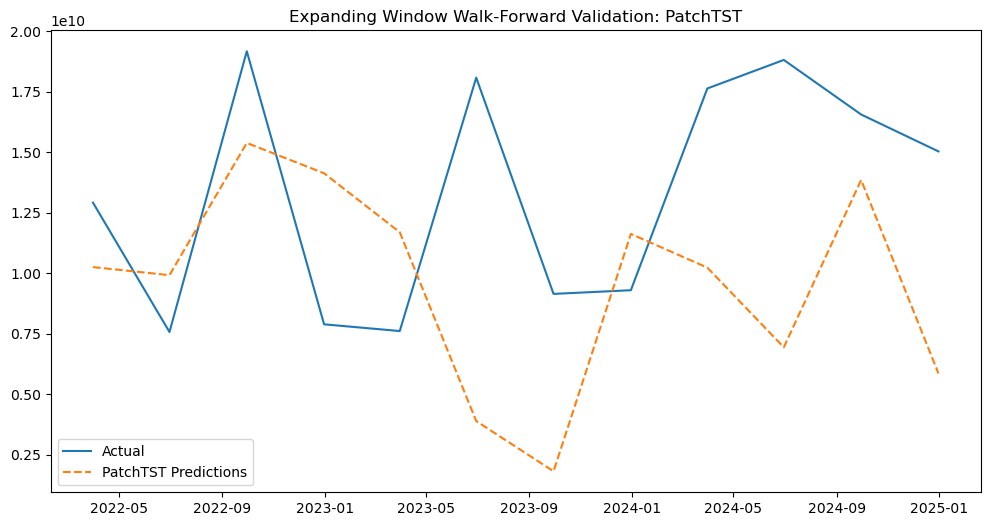

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



🚀 Running Expanding Window Walk-Forward Validation for Autoformer...



  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MQLoss        | 5      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 148 K  | train
7 | decoder       | Decoder       | 143 K  | train
--------------------------------------------------------
292 K     Trainable params
5         Non-trainable params
292 K     Total params
1.170     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Step 19: Trained on 19 samples, Tested on 4 samples


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MQLoss        | 5      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 148 K  | train
7 | decoder       | Decoder       | 143 K  | train
--------------------------------------------------------
292 K     Trainable params
5         Non-trainable params
292 K     Total params
1.170     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Step 23: Trained on 23 samples, Tested on 4 samples


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MQLoss        | 5      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 148 K  | train
7 | decoder       | Decoder       | 143 K  | train
--------------------------------------------------------
292 K     Trainable params
5         Non-trainable params
292 K     Total params
1.170     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 27: Trained on 27 samples, Tested on 4 samples


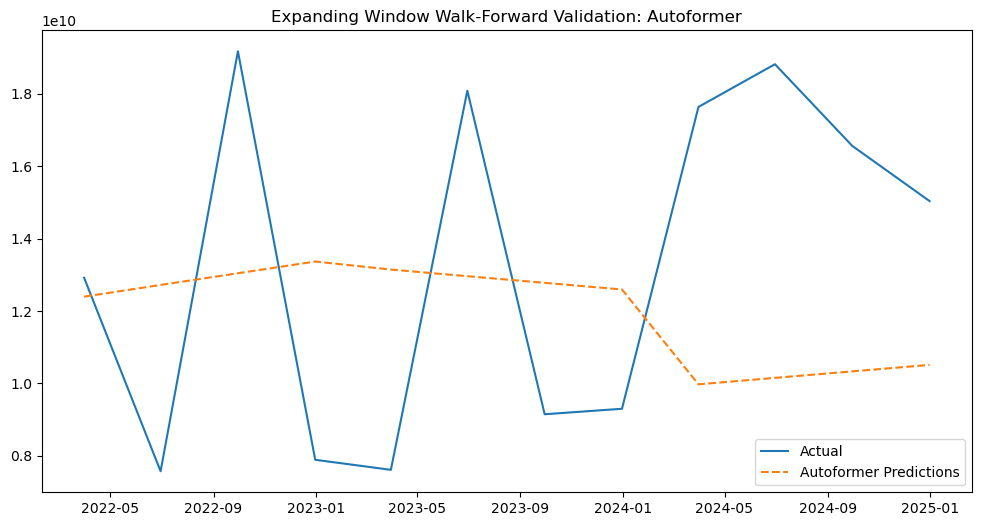

In [11]:
models = get_models(input_size=12)
wfv_results = walk_forward_validation(models, sap_df, forecast_horizon=4)

In [12]:
# 📊 Compare Walk-Forward Validation Results
sorted_results = sorted(wfv_results.items(), key=lambda x: x[1]["MAPE"], reverse=False)
print("\n📊 Walk-Forward Validation Model Performance (Sorted by MAPE Score):")
for model, scores in sorted_results:
    print(f"{model}: RMSE = {scores['RMSE']:.4f}, MAPE = {scores['MAPE']:.4f}, R² Score = {scores['R2 Score']:.4f}")


📊 Walk-Forward Validation Model Performance (Sorted by MAPE Score):
LSTM: RMSE = 5143873133.7148, MAPE = 39.3071, R² Score = -0.2790
TCN: RMSE = 5261595412.8252, MAPE = 41.8780, R² Score = -0.3383
Autoformer: RMSE = 5541549740.2370, MAPE = 42.2429, R² Score = -0.4845
NHITS: RMSE = 7212699858.9862, MAPE = 42.5606, R² Score = -1.5148
RNN: RMSE = 5336156418.7138, MAPE = 42.8578, R² Score = -0.3765
PatchTST: RMSE = 7251277253.0063, MAPE = 47.5397, R² Score = -1.5418
BiTCN: RMSE = 8631485397.6830, MAPE = 47.6177, R² Score = -2.6014
NBEATS: RMSE = 8135821951.3631, MAPE = 52.2269, R² Score = -2.1997
DLinear: RMSE = 7461232229.2029, MAPE = 52.2333, R² Score = -1.6911
TFT: RMSE = 8562886199.6885, MAPE = 62.7929, R² Score = -2.5444


In [13]:
sorted_results

[('LSTM',
  {'MAE': 4541460397.75,
   'MSE': 2.6459430815752835e+19,
   'RMSE': 5143873133.714792,
   'MAPE': 39.307100476325196,
   'SMAPE': 35.12985659433542,
   'R2 Score': -0.27904069423675537}),
 ('TCN',
  {'MAE': 4389075629.75,
   'MSE': 2.768438628826364e+19,
   'RMSE': 5261595412.825243,
   'MAPE': 41.87796984244952,
   'SMAPE': 34.11798996196687,
   'R2 Score': -0.33825480937957764}),
 ('Autoformer',
  {'MAE': 5162949614.916667,
   'MSE': 3.0708773523520885e+19,
   'RMSE': 5541549740.237011,
   'MAPE': 42.24286287415426,
   'SMAPE': 40.93278912057969,
   'R2 Score': -0.4844527244567871}),
 ('NHITS',
  {'MAE': 5659282188.583333,
   'MSE': 5.202303925581979e+19,
   'RMSE': 7212699858.986217,
   'MAPE': 42.56061724201432,
   'SMAPE': 57.2969089271118,
   'R2 Score': -1.5147778987884521}),
 ('RNN',
  {'MAE': 4773090920.083333,
   'MSE': 2.8474565324980945e+19,
   'RMSE': 5336156418.713842,
   'MAPE': 42.85779069081759,
   'SMAPE': 36.99230436898747,
   'R2 Score': -0.3764517307281

In [14]:
# 📌 Select Best Model Based on Walk-Forward RMSE
best_model_name = sorted_results[0][0]
best_model = next(m for m in models if m.alias == best_model_name)

print(f"\n🚀 Best Model Selected: {best_model_name}")

# 📌 Train Best Model on Full Data and Generate Forecast
nf_best = NeuralForecast(models=[best_model], freq='Q')
nf_best.fit(df=train)
forecast_df = nf_best.predict()

# Evaluate Best Model
results = []
for model_name in forecast_df.columns:
    if model_name in ["ds", "unique_id"]:
        continue
    y_pred = forecast_df[model_name]
    results.append(evaluate_model(val["y"], y_pred[:len(val["y"])], model_name, time.time()))




🚀 Best Model Selected: LSTM


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 24.1 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
510 K     Trainable params
0         Non-trainable params
510 K     Total params
2.042     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [15]:
# Convert results to DataFrame and display
df_results = pd.DataFrame(results).sort_values(by="MAPE", ascending=True)
print(df_results.head())

  Model           MSE           MAE      MAPE  SMAPE   R² Score  Time (s)
0  LSTM  5.920234e+19  7.152259e+09  0.401587    NaN -21.383152  0.003393


In [16]:
# 📊 Compare Walk-Forward Validation Results
sorted_results = sorted(wfv_results.items(), key=lambda x: x[1]["MAPE"], reverse=False)
print("\n📊 Walk-Forward Validation Model Performance (Sorted by MAPE):")
for model, scores in sorted_results:
    print(f"{model}: RMSE = {scores['RMSE']:.4f}, MAPE = {scores['MAPE']:.4f}, R² Score = {scores['R2 Score']:.4f}")


📊 Walk-Forward Validation Model Performance (Sorted by MAPE):
LSTM: RMSE = 5143873133.7148, MAPE = 39.3071, R² Score = -0.2790
TCN: RMSE = 5261595412.8252, MAPE = 41.8780, R² Score = -0.3383
Autoformer: RMSE = 5541549740.2370, MAPE = 42.2429, R² Score = -0.4845
NHITS: RMSE = 7212699858.9862, MAPE = 42.5606, R² Score = -1.5148
RNN: RMSE = 5336156418.7138, MAPE = 42.8578, R² Score = -0.3765
PatchTST: RMSE = 7251277253.0063, MAPE = 47.5397, R² Score = -1.5418
BiTCN: RMSE = 8631485397.6830, MAPE = 47.6177, R² Score = -2.6014
NBEATS: RMSE = 8135821951.3631, MAPE = 52.2269, R² Score = -2.1997
DLinear: RMSE = 7461232229.2029, MAPE = 52.2333, R² Score = -1.6911
TFT: RMSE = 8562886199.6885, MAPE = 62.7929, R² Score = -2.5444


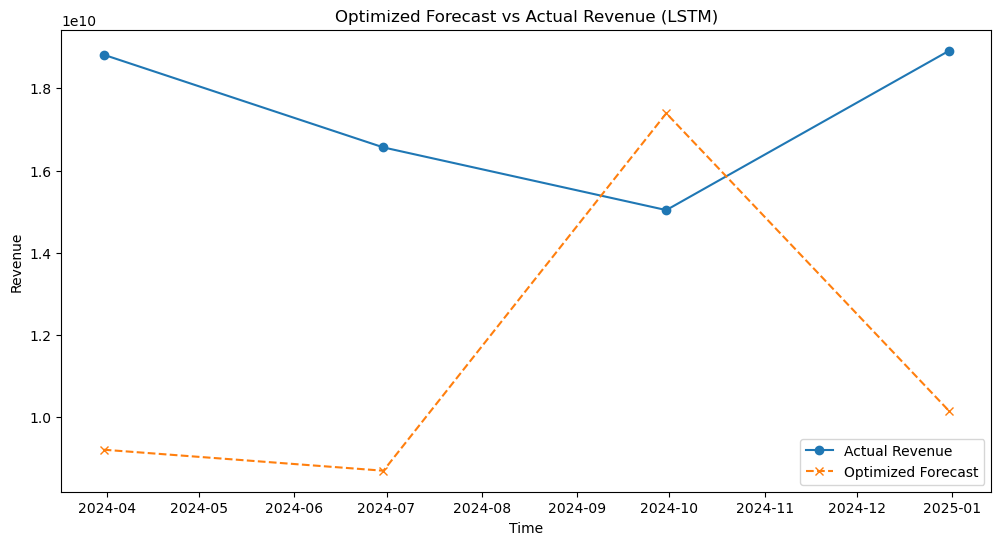

In [17]:
# %%
# 📌 Plot Optimized Forecast vs Actual
plt.figure(figsize=(12, 6))
plt.plot(val["ds"], val["y"], label="Actual Revenue", marker="o")
plt.plot(val["ds"], y_pred[:len(val["y"])], label="Optimized Forecast", linestyle="dashed", marker="x")
plt.xlabel("Time")
plt.ylabel("Revenue")
plt.title(f"Optimized Forecast vs Actual Revenue ({best_model_name})")
plt.legend()
plt.show()